In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf
#from scipy.misc import imread, imsave
#import cv2  Cannot import
from matplotlib import pyplot as plt


import sys
import os
from PIL import Image
from glob import glob
import math
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8ascwwve because the default path (/home/cse479/izzatadly/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 12288)             151007232 
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12288)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 12288)             151007232 
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12288)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 12288)             151007232 
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 12288)             0

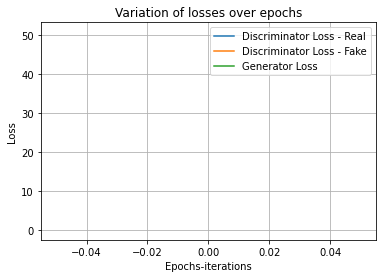

50
0 1 [D loss: 1.036623, acc.: 94.00%] [G loss: 3.578828]
Saved model to disk
50
1 0 [D loss: 73.056748, acc.: 48.00%] [G loss: 68.021935]


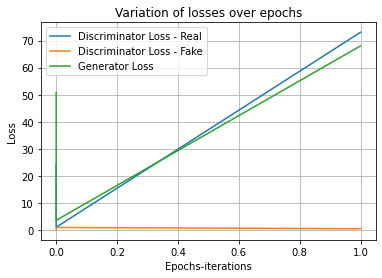

50
1 1 [D loss: 2.933079, acc.: 90.00%] [G loss: 192.943756]
Saved model to disk
50
2 0 [D loss: 9.120764, acc.: 90.00%] [G loss: 102.859772]


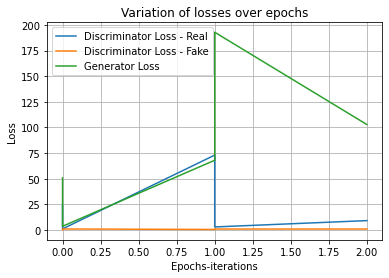

50
2 1 [D loss: 5.898004, acc.: 94.00%] [G loss: 0.248189]
Saved model to disk
50
3 0 [D loss: 102.559757, acc.: 46.00%] [G loss: 0.003061]


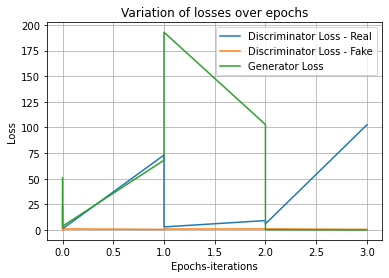

50
3 1 [D loss: 0.000004, acc.: 100.00%] [G loss: 21.900860]
Saved model to disk
50
4 0 [D loss: 0.728662, acc.: 98.00%] [G loss: 22.120693]


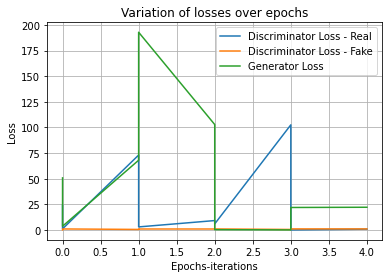

50
4 1 [D loss: 4.642359, acc.: 90.00%] [G loss: 10.718525]
Saved model to disk
50
5 0 [D loss: 1.475424, acc.: 90.00%] [G loss: 0.019622]


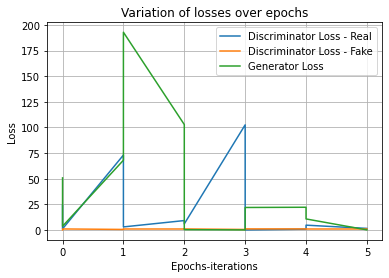

50
5 1 [D loss: 2.400480, acc.: 48.00%] [G loss: 10.689922]
Saved model to disk


In [2]:
class GAN():
    def __init__(self):
        self.img_rows = 64 
        self.img_cols = 64
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        optimizer = Adam(0.0002)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(4096,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        noise_shape = (4096,)
        
        model = Sequential()

        model.add(Dense(500, input_shape=noise_shape))
        model.add(LeakyReLU(0.2))
        
        model.add(Dense(64 * 64 * 3))
        model.add(LeakyReLU(0.2))
        
        model.add(Dense(64 * 64 * 3))
        model.add(LeakyReLU(0.2))
        
        model.add(Dense(64 * 64 * 3, activation = "sigmoid"))
        model.add(Reshape([64, 64, 3]))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()
        model.add(Flatten(input_shape=img_shape))
        
        model.add(Dense(64 * 64 * 3))
        model.add(LeakyReLU(0.2))
        
        model.add(Dense(64 * 64 * 3))
        model.add(LeakyReLU(0.2))
        
        model.add(Dense(64 * 64 * 3))
        model.add(LeakyReLU(0.2))
        
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def get_image(self, image_path, width, height, mode):  
        image = Image.open(image_path)
        image = image.resize([width, height])
        #print("img",image)
        return np.array(image.convert(mode))

    def get_batch(self, image_files, width, height, mode):
        #print(image_files)
        data_batch = np.array([self.get_image(sample_file, width, height, mode) for sample_file in image_files])
        
        return data_batch    
    def add_noise(self,image):
        ch = 3
        row,col = 64,64
        #print(row,col,ch)
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        #print(gauss.shape)
        noisy = image + gauss
        #print(gauss.shape)
        #plt.imshow(noisy)
        #plt.show()
        #print(noisy.shape)
        image = tf.image.resize(noisy, (64, 64))    
        return image
    
    def plot(d_loss_logs_r_a,d_loss_logs_f_a,g_loss_logs_a):
        #Generate the plot at the end of training
        #Convert the log lists to numpy arrays
        d_loss_logs_r_a = np.array(d_loss_logs_r_a)
        d_loss_logs_f_a = np.array(d_loss_logs_f_a)
        g_loss_logs_a = np.array(g_loss_logs_a)
        plt.plot(d_loss_logs_r_a[:,0], d_loss_logs_r_a[:,1], label="Discriminator Loss - Real")
        plt.plot(d_loss_logs_f_a[:,0], d_loss_logs_f_a[:,1], label="Discriminator Loss - Fake")
        plt.plot(g_loss_logs_a[:,0], g_loss_logs_a[:,1], label="Generator Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Variation of losses over epochs')
        plt.grid(True)
        plt.show()    
        
    def train(self, epochs, batch_size=128, save_interval=50):
        data_dir = "img_align_celeba/img_align_celeba" # Cannot seem to find my folder on crane for some reason.
        filepaths=os.listdir(data_dir)
        
        #print(X_train)
        #Rescale -1 to 1
        
        half_batch = int(batch_size / 2)
        #Create lists for logging the losses
        d_loss_logs_r = []
        d_loss_logs_f = []
        g_loss_logs = []
        n_iterations=math.floor(len(filepaths)/batch_size)
        print(n_iterations)
        for epoch in range(epochs):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            # Select a random half batch of images
            for ite in range(n_iterations):
#                 X_train=np.array([self.add_noise(image) for image in X_train])
                X_train = self.get_batch(glob(os.path.join(data_dir, '*.jpg'))[ite*batch_size:(ite+1)*batch_size], 64, 64, 'RGB')
                X_train = (X_train.astype(np.float32) - 127.5) / 127.5
                X_train=np.array([self.add_noise(image) for image in X_train])
                print(X_train.shape[0])
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]
                noise = np.random.normal(0, 1, (half_batch, 4096))
                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)
                # Train the discriminator
                d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                # ---------------------
                #  Train Generator
                # ---------------------
                noise = np.random.normal(0, 1, (batch_size, 4096))
                #np.random.normal(0, 1, (batch_size, 4096))
                # The generator wants the discriminator to label the generated samples
                # as valid (ones)
                valid_y = np.array([1] * batch_size)
                # Train the generator
                g_loss = self.combined.train_on_batch(noise, valid_y)
                # Plot the progress
                print ("%d %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,ite, d_loss[0], 100*d_loss[1], g_loss))

                #Append the logs with the loss values in each training step
                d_loss_logs_r.append([epoch, d_loss[0]])
                d_loss_logs_f.append([epoch, d_loss[1]])
                g_loss_logs.append([epoch, g_loss])

                d_loss_logs_r_a = np.array(d_loss_logs_r)
                d_loss_logs_f_a = np.array(d_loss_logs_f)
                g_loss_logs_a = np.array(g_loss_logs)

                # If at save interval => save generated image samples
                if ite % save_interval == 0:
                    self.save_imgs(epoch,ite)

                    plt.plot(d_loss_logs_r_a[:,0], d_loss_logs_r_a[:,1], label="Discriminator Loss - Real")
                    plt.plot(d_loss_logs_f_a[:,0], d_loss_logs_f_a[:,1], label="Discriminator Loss - Fake")
                    plt.plot(g_loss_logs_a[:,0], g_loss_logs_a[:,1], label="Generator Loss")
                    plt.xlabel('Epochs-iterations')
                    plt.ylabel('Loss')
                    plt.legend()
                    plt.title('Variation of losses over epochs')
                    plt.grid(True)
                    plt.show()    



            
            model_json = self.generator.to_json()
            
            # Error with this part
            with open("model"+str(epoch)+".json", "w") as json_file:
                json_file.write(model_json)
                
                
            # serialize weights to HDF5
            self.generator.save_weights("model"+str(epoch)+".h5")
            print("Saved model to disk")
        '''
        for i,i_path in enumerate(os.listdir('../input/sketch-to-images-resized-photos2/resized photos2zip/new_imgs')):
            if i < 25:
                path = os.path.join('../input/sketch-to-images-resized-photos2/resized photos2zip/new_imgs/'+i_path)
    
                img = cv2.imread(path,0)
    
                img= cv2.resize(img,(64,64))
                img=img.reshape((1,4096))
                gen_imgs = self.generator.predict(img)
                gen_imgs1 = (1/2.5) * gen_imgs[0] + 0.5
                #fig.savefig("%d.png" % epoch)
                print(gen_imgs.shape)
                cv2.imwrite("gen_imgs"+i_path,gen_imgs)
                cv2.imwrite("gen_imgs1"+i_path,gen_imgs1)
                plt.imshow(gen_imgs[0])
                plt.show()
        '''
        
    def save_imgs(self, epoch,iteration):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 4096))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = (1/2.5) * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(str(epoch)+"-"+str(iteration)+".png")
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    gan.train(epochs=6, batch_size=50, save_interval=200)